In [1]:
import h5py
import pandas as pd
import numpy as np

from data.processing import one_hot_encode, reverse_complement

from deepliftmotifs import Trainer
from motifs import DijkMotifs, FimoMotifs, StubMotifs
import numpy as np
import pandas as pd
from modisco.visualization import viz_sequence

from dijk import get_ordered_data_with_annotations
from collections import defaultdict as ddict
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
TF-MoDISco is using the TensorFlow backend.


In [18]:
def get_sharpr_data(size=-1):
    ### rip memory
    data = pd.read_csv('./data/sharpr/sharprFullDataMatrix.tsv', delimiter='\t').iloc[:size]
    cols = [c for c in data.columns if 'hepg2' in c and 'avg' not in c]
    indices = [i for i, s in enumerate(data['sequence'].values) if 'N' not in s]
    X_reg = np.stack([one_hot_encode(s) for s in data['sequence'].iloc[indices].values])
    X_comp = np.stack([one_hot_encode(reverse_complement(s)) for s in data['sequence'].iloc[indices].values])
    X = np.zeros((X_reg.shape[0], 2, X_reg.shape[1], X_reg.shape[2]))
    X[:, 0, :, :] = X_reg
    X[:, 1, :, :] = X_comp
    
    Y = data[cols].iloc[indices].values
    return X, Y

[autoreload of deepliftmotifs failed: Traceback (most recent call last):
  File "/home/ryan/anaconda3/envs/ai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/ryan/anaconda3/envs/ai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/home/ryan/anaconda3/envs/ai/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/ryan/anaconda3/envs/ai/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  Fi

In [19]:
x,y = get_sharpr_data()

In [25]:
t = Trainer(StubMotifs(length=x.shape[0]), X=x, Y=y)

In [26]:
x.shape, y.shape

((487130, 2, 145, 4), (487130, 8))

In [31]:
seqmodel = t.trainFullSequence(epochs=100, input_shape=(145,4), output_shape=8)

Epoch 1/100
779408/779408 [==============================] - 121s 156us/step - loss: 58543.1230
Epoch 2/100
779408/779408 [==============================] - 116s 149us/step - loss: 58398.5064
Epoch 3/100
779408/779408 [==============================] - 116s 149us/step - loss: 58392.3474
Epoch 4/100
395776/779408 [==============>...............] - ETA: 58s - loss: 60644.3995

KeyboardInterrupt: 

In [ ]:
scores, hypothetical_scores = t.getScores(seqmodel, sequence_length=145)

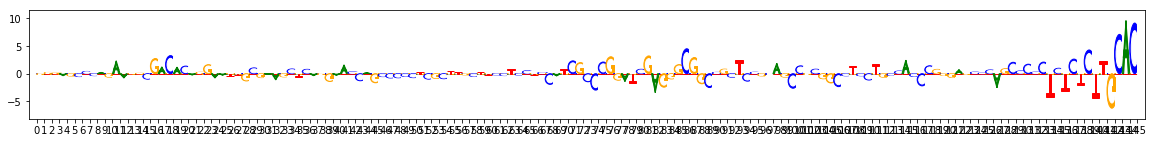

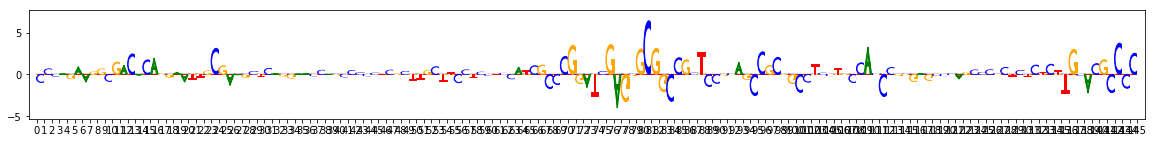

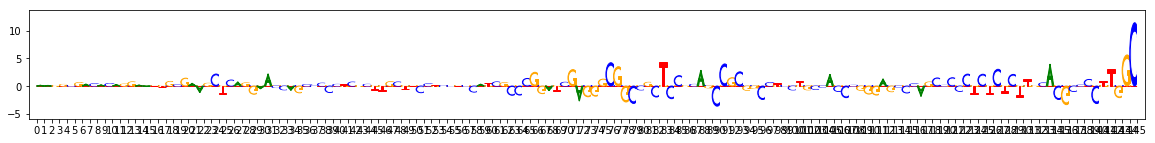

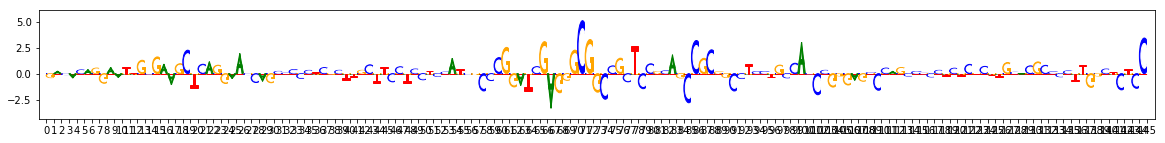

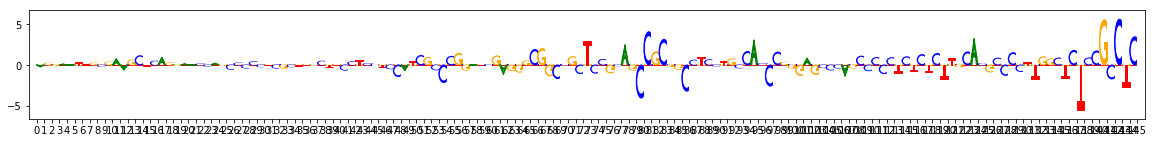

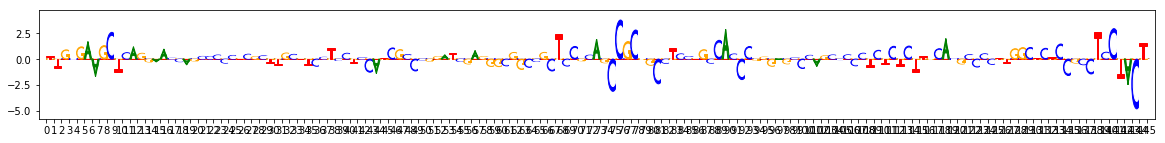

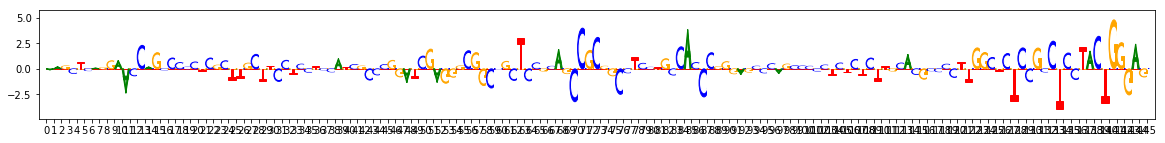

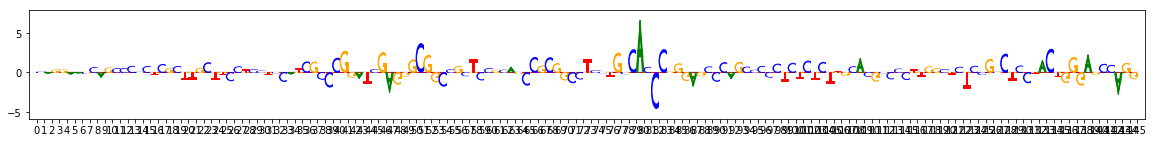

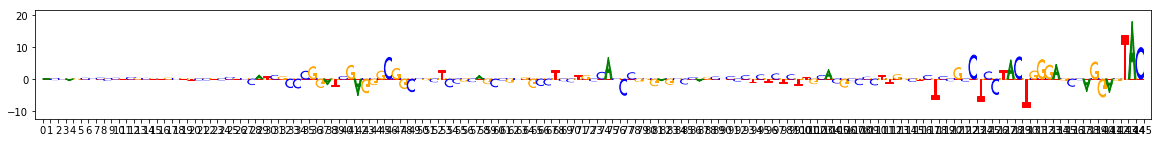

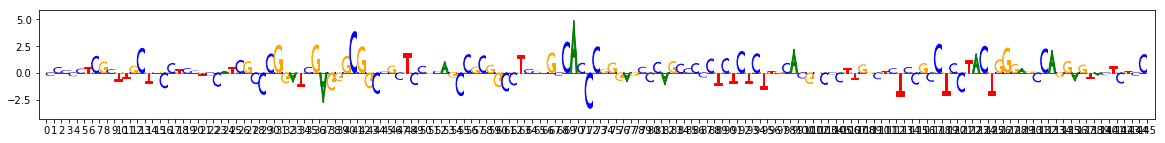

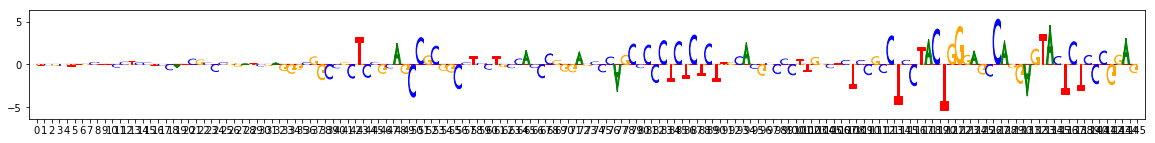

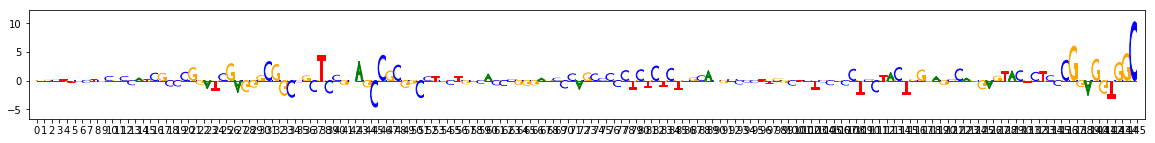

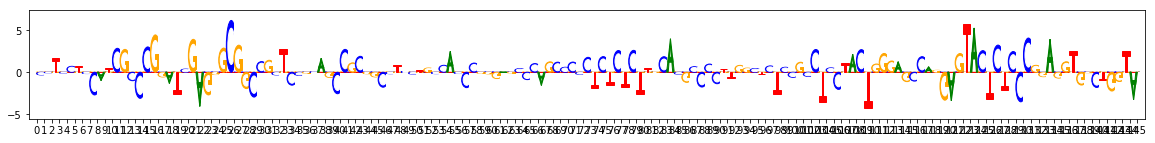

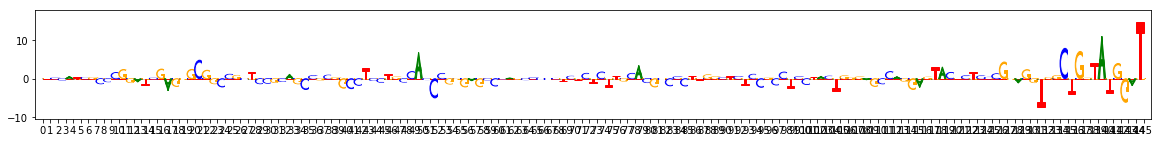

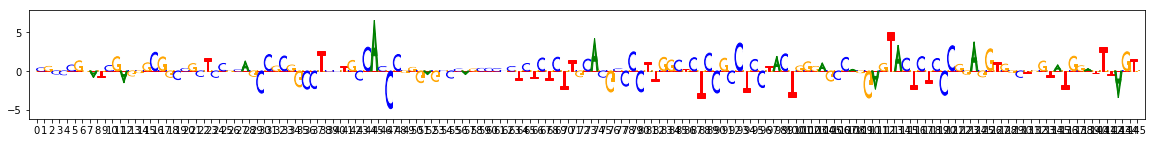

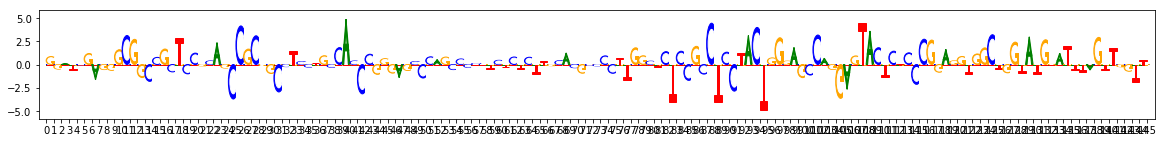

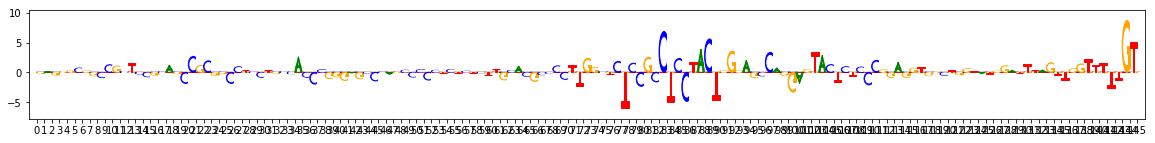

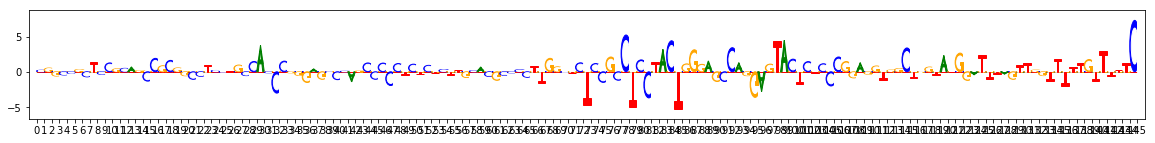

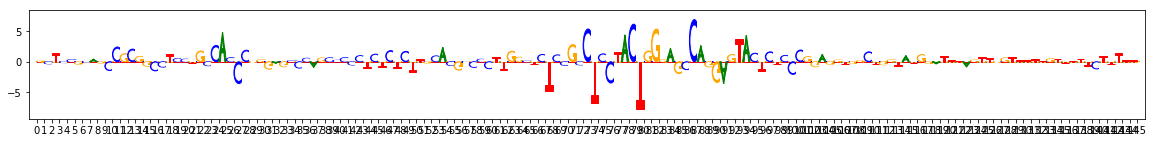

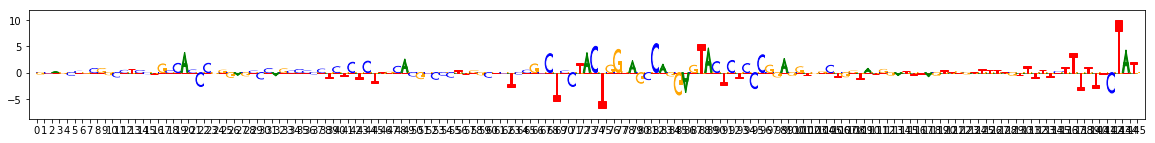

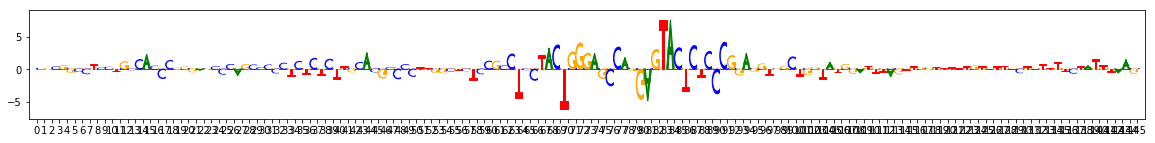

In [15]:
t.plotDeepLift(scores, num=20, verbose=True)

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= 0.9259022827148438
Computing threshold
Thresholds from null dist were -28.835729598999023  and  55.53509521484375
Final raw thresholds are -28.835729598999023  and  55.53509521484375
Final transformed thresholds are -0.916632  and  0.962272


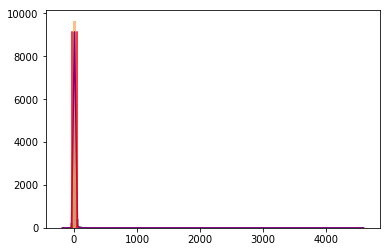

Got 3695 coords
After resolving overlaps, got 3695 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9166319
3695 identified in total
2 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [2571, 1124]
Idx to activities:  {0: '1', 1: '-1'}
On metacluster 1
Metacluster size 1124
Relevant tasks:  ('task0',)
Relevant signs:  (-1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 1124
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 3.86 s
Starting affinity matrix computations
Normalization computed in 0.32 s
Cosine similarity mat computed in 0.8 s
Normalization computed in 0.32 s
Cosine similarity mat computed in 0.82 s
Finished affinity matrix computations in 1.65 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.06 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affma

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.0s finished


Louvain completed 200 runs in 3.6429224014282227 seconds
Wrote graph to binary file in 0.754258394241333 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.602202
After 2 runs, maximum modularity is Q = 0.607465
After 3 runs, maximum modularity is Q = 0.610003
After 4 runs, maximum modularity is Q = 0.624691
After 35 runs, maximum modularity is Q = 0.630173
After 44 runs, maximum modularity is Q = 0.633764
Louvain completed 94 runs in 11.649960994720459 seconds
Preproc + Louvain took 16.300349950790405 s
Got 16 clusters after round 1
Counts:
{1: 120, 9: 31, 5: 57, 2: 105, 13: 18, 7: 45, 0: 243, 11: 27, 8: 41, 6: 48, 10: 28, 4: 96, 3: 102, 12: 23, 14: 15, 15: 7}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 243 seqlets
Trimmed 2 out of 243
Skipped 70 seqlets
Skipped 15 seqlets
Dropping cluster 0 with 154 seqlets due to sign disagreement
Aggregating for cluster 1 with 120 seqlets
Trimmed 29 out of 120
Skipped 8 seqlets

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.2s finished


Louvain completed 200 runs in 4.689823627471924 seconds
Wrote graph to binary file in 0.48888492584228516 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.894679
After 6 runs, maximum modularity is Q = 0.89616
Louvain completed 56 runs in 6.663902282714844 seconds
Preproc + Louvain took 12.366132259368896 s
Got 59 clusters after round 1
Counts:
{7: 51, 3: 56, 1: 88, 8: 48, 5: 55, 10: 46, 39: 16, 2: 85, 18: 33, 14: 36, 11: 45, 15: 35, 35: 19, 36: 19, 26: 22, 16: 34, 6: 53, 27: 22, 31: 20, 20: 32, 19: 32, 37: 18, 47: 13, 13: 36, 4: 55, 32: 20, 38: 16, 34: 19, 22: 28, 12: 37, 42: 14, 30: 20, 25: 23, 53: 11, 17: 34, 23: 24, 0: 128, 46: 13, 33: 19, 21: 31, 9: 47, 41: 15, 50: 12, 24: 23, 45: 14, 55: 10, 28: 21, 54: 10, 49: 12, 40: 16, 57: 10, 44: 14, 52: 11, 51: 12, 29: 21, 56: 10, 43: 14, 48: 13, 58: 9}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 128 seqlets
Trimmed 5 out of 128
Skipped 83 seqlets
Aggregating for clus

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.4s finished


Louvain completed 200 runs in 2.913820743560791 seconds
Wrote graph to binary file in 0.13628506660461426 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.874618
After 2 runs, maximum modularity is Q = 0.880985
After 8 runs, maximum modularity is Q = 0.885579
After 13 runs, maximum modularity is Q = 0.890708
After 39 runs, maximum modularity is Q = 0.895695
Louvain completed 89 runs in 14.88800048828125 seconds
Preproc + Louvain took 18.251988649368286 s
Got 43 clusters after round 2
Counts:
{0: 68, 15: 20, 3: 59, 4: 55, 10: 23, 5: 34, 31: 12, 6: 29, 7: 28, 11: 23, 2: 61, 17: 20, 22: 16, 1: 66, 13: 22, 28: 13, 9: 23, 32: 11, 16: 20, 12: 22, 21: 17, 23: 16, 27: 14, 18: 18, 8: 24, 39: 9, 20: 18, 25: 15, 24: 16, 19: 18, 33: 11, 40: 8, 26: 14, 34: 11, 29: 13, 35: 11, 30: 12, 14: 20, 36: 10, 37: 9, 38: 9, 42: 5, 41: 8}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 68 seqlets
Trimmed 8 out of 68
Skipped 7 seqlets
Aggrega

After 1 runs, maximum modularity is Q = 0.0515732
Louvain completed 21 runs in 3.4806056022644043 seconds
Similarity is 0.44520664; is_dissimilar is True
Got 3 subclusters
Inspecting for spurious merging
Wrote graph to binary file in 0.009980916976928711 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = -0.0189487
After 4 runs, maximum modularity is Q = 0.0107553
After 7 runs, maximum modularity is Q = 0.0108109
Louvain completed 27 runs in 4.255126953125 seconds
Similarity is -0.03660205; is_dissimilar is True
Got 2 subclusters
Inspecting for spurious merging
Wrote graph to binary file in 0.010930776596069336 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.0342706
Louvain completed 21 runs in 2.7641546726226807 seconds
Similarity is 0.4786579; is_dissimilar is True
Got 2 subclusters
Inspecting for spurious merging
Wrote graph to binary file in 0.007762908935546875 seconds
Running Louvain modularity optimiz

In [16]:
tfmodisco = t.tfmodiscoResults(scores, hypothetical_scores)

Metaclusters heatmap


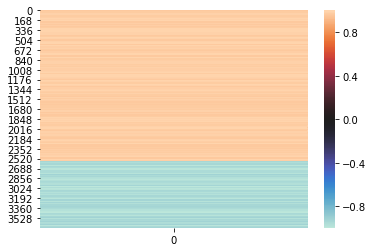

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
Task 0 hypothetical scores:


/home/ryan/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


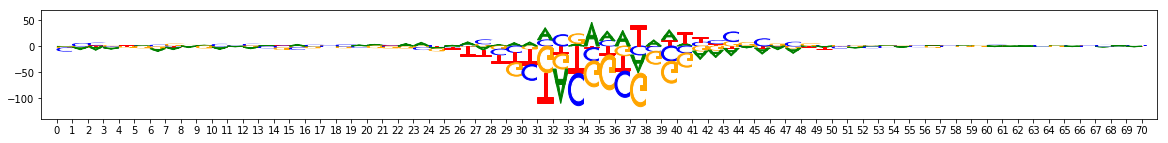

Task 0 actual importance scores:


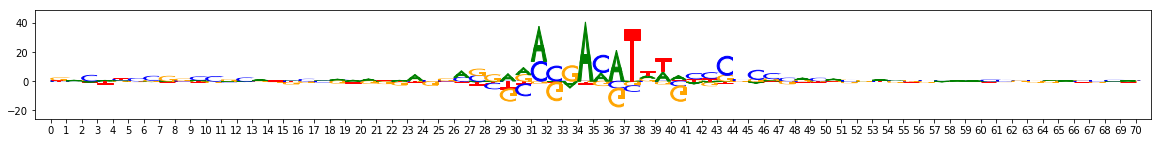

onehot, fwd and rev:


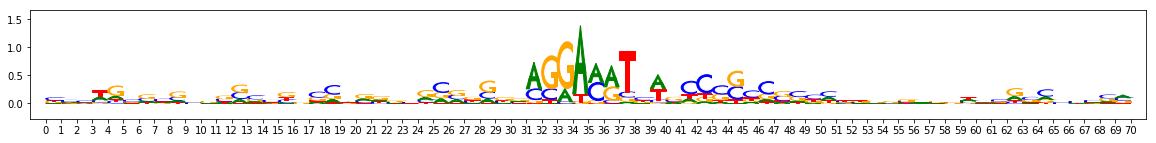

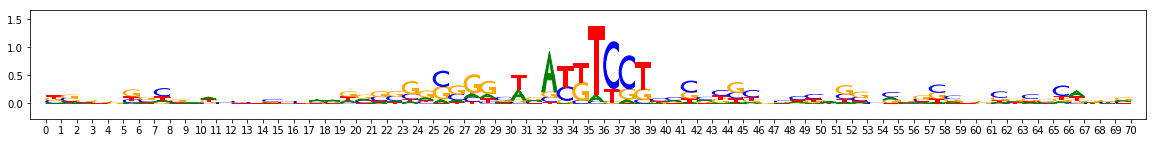

metacluster_1
activity pattern: [-1]


KeyError: "Unable to open object (object 'patterns' doesn't exist)"

In [17]:
from collections import Counter
from modisco.visualization import viz_sequence
from matplotlib import pyplot as plt

import modisco.affinitymat.core
import modisco.cluster.phenograph.core
import modisco.cluster.phenograph.cluster
import modisco.cluster.core
import modisco.aggregator
import h5py

!rm 'tfmodiscoresults.hdf5'
grp = h5py.File('tfmodiscoresults.hdf5')
tfmodisco.save_hdf5(grp)
hdf5_results = h5py.File('tfmodiscoresults.hdf5', 'r')

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

ids = set()

all_patterns = []
for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        #print(pattern["seqlets_and_alnmts"]["seqlets"].value)
        
        for s in pattern['seqlets_and_alnmts']['seqlets'].value:
            ids.add(int(s.decode().split(',')[0].split(':')[1]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
